In [2]:
#%% Importing modules and functions
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from funsTG import torusGraphs
import networkx as nx

In [3]:
#%% load Data
dataMat = loadmat('anglebeta.mat')
X = dataMat['anglebeta']

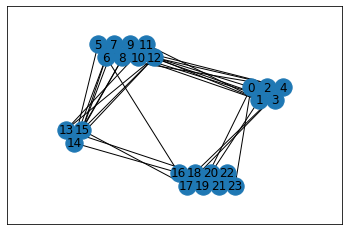

In [4]:
#%% Drawing the electrodes Network Graph with default settings:
# edgesAlphaLevel=0.05, 
# selMode=(True, True, True)
elecEdgesGraph, num, pairsElec, pairsElecGroup, phiHat, covPhiHat \
    = torusGraphs(X)

# explicitly set positions
pos = {0: (21, 5), 1: (22, 4.7), 2: (23, 5), 3: (24, 4.7), 4: (25, 5), \
       5: (2, 6), 6: (3, 5.7), 7: (4, 6), 8: (5, 5.7), 9: (6, 6), 10: (7, 5.7), 11: (8, 6), 12: (9, 5.7), \
       13: (-2, 4), 14: (-1, 3.7), 15: (0, 4),\
       16: (12, 3), 17: (13, 2.7), 18: (14, 3), 19: (15, 2.7), 20: (16, 3), 21: (17, 2.7), 22: (18, 3), 23: (19, 2.7)}

nx.draw_networkx(elecEdgesGraph, pos)

ax2 = plt.gca()
ax2.margins(0.20)
# plt.axis("off")
plt.show()

pVals for group-edges (6.791842251572988e-126, 9.370529280731905e-17, 1.7436861957095085e-23, 5.81259620796497e-48, 0.004302010686980084, 2.4752276121911805e-07)


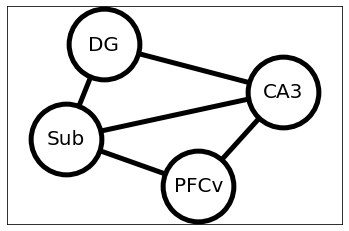

In [6]:
#%% Drawing Grouped-electrodes Network Graph with custom settings
elecGroupLabels= [x[0].tolist().pop() for x in dataMat['subregions']]
groupLabels = ('CA3', 'DG', 'Sub', 'PFCv')
elecGroupNumLabels = [[] for _ in elecGroupLabels]
for iElectrode,label in enumerate(elecGroupLabels):
    elecGroupNumLabels[iElectrode] = groupLabels.index(label)
# groupEdgesAlphaLevel = 0.001/6 # bf correction

groupElecEdgesGraph, num, pairsElec, pairsElecGroup, phiHat, covPhiHat \
    = torusGraphs(X, elecGroupNumLabels = elecGroupNumLabels,\
         edgesAlphaLevel=0.05, 
         groupEdgesAlphaLevel=0.001/6, 
         selMode=(True, True, False))

print('pVals for group-edges', pairsElecGroup['pVals'])

pos = {'CA3': (21, 5), 'DG': (2, 6), 'Sub': (-2, 4), 'PFCv': (12, 3)}
options = {
    "font_size": 20,
    "node_size": 5000,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 5,
    "width": 5,
}
# adding sub-region labels to graph
mapping = dict(zip(groupElecEdgesGraph, groupLabels))
groupElecEdgesGraph = nx.relabel_nodes(groupElecEdgesGraph, mapping)  # nodes are characters a through z

nx.draw_networkx(groupElecEdgesGraph, pos, **options)

ax = plt.gca()
ax.margins(0.20)
# plt.axis("off")
plt.show()